<a href="https://colab.research.google.com/github/FariusGitHub/DataScience/blob/master/shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# _score formula from Elasticsearch 6.0 onwards
Farius Tjioesman, April 26, 2021

Many older articles about _score calculation may be written for older Elasticsearch version <br>
that using classic TF-IDF rather than BM25. I would like to use Shakespeare dataset to <br>
explore this exercise. It is mainly inspired from Anirudh Dey from August 2020 article below.

https://codeburst.io/deconstructing-scoring-in-elasticsearch-e8544676a24

The elasticseach score was derived from the multiplication of three components <br> Boost factor, idf factor and tf factor.

Herewith is the formula for tf

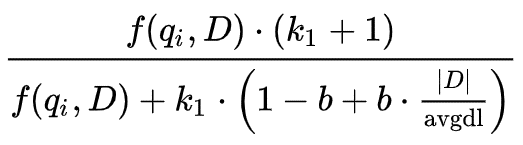

And Herewith is the formula for idf 

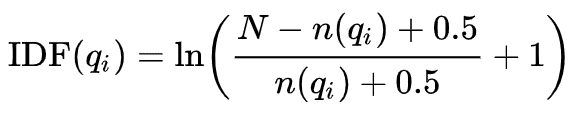

In [1]:
from time import sleep

In [2]:
# install es server
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.0.0-linux-x86_64.tar.gz -q --show-progress
!tar -xzf elasticsearch-7.0.0-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.0.0

elasticsearch-7.0.0 100%[===================>] 330.70M  36.2MB/s    in 8.0s    


In [3]:
# The server may take some time prior to get response from Virtual Environment
sleep(20)

In [4]:
# start server and check es virtual machine connection
import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.0.0/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )
# wait a bit then test, if failed than re-run this cell
!curl -X GET "localhost:9200/"

{
  "name" : "b8aab1d1ea3d",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "3eHoEffkQd-s_ivQS-9V5Q",
  "version" : {
    "number" : "7.0.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "b7e28a7",
    "build_date" : "2019-04-05T22:55:32.697037Z",
    "build_snapshot" : false,
    "lucene_version" : "8.0.0",
    "minimum_wire_compatibility_version" : "6.7.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [7]:
# client-side
!pip install elasticsearch -q
from tqdm import tqdm
import sys
import json
import ast
from pprint import pprint
# Import Elasticsearch package 
from elasticsearch import Elasticsearch 
es = Elasticsearch()
es.ping()  # got True

True

In [9]:
import urllib.request
import json
from tqdm import tqdm
url="https://raw.githubusercontent.com/ropensci/elastic_data/master/data/shakespeare_data.json"
with urllib.request.urlopen(url) as response:
   html = response.read()

#There are 5000 documents split by 10000 /n (new lines)
#I used odd-even list data collection/zipping prior to ingest to elasticsearch    
docs=list(zip(html[57:].decode("utf-8").split('\n')[1::2],html[57:].decode("utf-8").split('\n')[0::2]))

In [10]:
for i in tqdm(range(len(docs))):
    
    request_body = {
    "settings": {
        "number_of_shards": 5,
        "number_of_replicas": 1
    },
    'mappings': {
        'examplecase': {
            'properties': {
                'tbl_id': {'type': 'keyword'},
                'texts': {'type': 'text'},
            }
        }
    },
    'id' : list(ast.literal_eval(docs[i][1]).values())[0],
    'text_entry' : list(ast.literal_eval(docs[i][1]).values())[5]
    }
    
    es.index(index='shakespeare', doc_type='Blog', id=i+1, body=request_body)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Specifying types in document index requests is deprecated, use the typeless endpoints instead (/{index}/_doc/{id}, /{index}/_doc, or /{index}/_create/{id}).
  warnings.warn(message, category=ElasticsearchWarning)
100%|██████████| 5000/5000 [01:07<00:00, 74.54it/s]


In [11]:
# Checking data integrity
!curl -X GET 'http://localhost:9200/shakespeare/_count?pretty'

{
  "count" : 5000,
  "_shards" : {
    "total" : 1,
    "successful" : 1,
    "skipped" : 0,
    "failed" : 0
  }
}


Using .search and enabling explaination (explain=True) we can follow along how _score was computed

Reference : <br>
https://marcobonzanini.com/2015/02/02/how-to-query-elasticsearch-with-python/ <br>
https://www.mathworks.com/help///textanalytics/ref/bagofwords.tfidf.html <br>
https://en.wikipedia.org/wiki/Okapi_BM25


In [21]:
#display the query for a word 'hundred'
result=es.search(index="shakespeare", explain=True, size=13, doc_type="Blog", body={"query": {"match": {"text_entry": "hundred"}}})
result

/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Specifying types in search requests is deprecated.
  warnings.warn(message, category=ElasticsearchWarning)


{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [{'_explanation': {'description': 'weight(text_entry:hundred in 643) [PerFieldSimilarity], result of:',
     'details': [{'description': 'score(freq=1.0), product of:',
       'details': [{'description': 'boost', 'details': [], 'value': 2.2},
        {'description': 'idf, computed as log(1 + (N - n + 0.5) / (n + 0.5)) from:',
         'details': [{'description': 'n, number of documents containing term',
           'details': [],
           'value': 12},
          {'description': 'N, total number of documents with field',
           'details': [],
           'value': 5000}],
         'value': 5.9916644},
        {'description': 'tf, computed as freq / (freq + k1 * (1 - b + b * dl / avgdl)) from:',
         'details': [{'description': 'freq, occurrences of term within document',
           'details': [],
           'value': 1.0},
          {'description': 'k1, term saturation parameter',
           'd

In [22]:
#to extract _score of first result
list(list(list(list(list(list(list(result.values())[3].values())[2])[0].values())[7].values())[2])[0].values())[0]

7.4381537

In [24]:
#to extract boost component of first result
list(list(list(list(list(list(list(list(result.values())[3].\
    values())[2])[0].values())[7].values())[2])[0].values())[2][0].values())[0] 

2.2

In [25]:
#to extract idf component of first result
list(list(list(list(list(list(list(list(result.values())[3].\
    values())[2])[0].values())[7].values())[2])[0].values())[2][1].values())[0] 

5.9916644

In [26]:
#to extract tf component of first result
list(list(list(list(list(list(list(list(result.values())[3].\
    values())[2])[0].values())[7].values())[2])[0].values())[2][2].values())[0] 

0.56428045

In [41]:
#checking the formula consistency for the 12 query found of 'hundred'
for i in range(len(list(list(result.values())[3].values())[2])):
    score=list(list(list(list(list(list(list(result.values())[3].\
      values())[2])[i].values())[7].values())[2])[0].values())[0]
    boost=list(list(list(list(list(list(list(list(result.values())[3].\
      values())[2])[i].values())[7].values())[2])[0].values())[2][0].values())[0] 
    idf=list(list(list(list(list(list(list(list(result.values())[3].\
      values())[2])[i].values())[7].values())[2])[0].values())[2][1].values())[0] 
    tf=list(list(list(list(list(list(list(list(result.values())[3].\
      values())[2])[i].values())[7].values())[2])[0].values())[2][2].values())[0]
    
    print(score, '=', boost, '*', idf, '*', tf, '--> error=', boost*idf*tf-score)

7.4381537 = 2.2 * 5.9916644 * 0.56428045 --> error= 2.845381574800854e-07
6.563747 = 2.2 * 5.9916644 * 0.49794534 --> error= 7.0125718565350326e-09
6.199358 = 2.2 * 5.9916644 * 0.47030172 --> error= 1.6056208984593923e-07
6.199358 = 2.2 * 5.9916644 * 0.47030172 --> error= 1.6056208984593923e-07
5.8732996 = 2.2 * 5.9916644 * 0.44556597 --> error= 2.726610297543175e-07
5.8732996 = 2.2 * 5.9916644 * 0.44556597 --> error= 2.726610297543175e-07
5.5798254 = 2.2 * 5.9916644 * 0.42330214 --> error= 1.9789999594621577e-07
5.5798254 = 2.2 * 5.9916644 * 0.42330214 --> error= 1.9789999594621577e-07
5.3142843 = 2.2 * 5.9916644 * 0.40315738 --> error= -1.1304480107554582e-07
5.3142843 = 2.2 * 5.9916644 * 0.40315738 --> error= -1.1304480107554582e-07
5.3142843 = 2.2 * 5.9916644 * 0.40315738 --> error= -1.1304480107554582e-07
5.072869 = 2.2 * 5.9916644 * 0.3848429 --> error= -9.224992769674145e-08
